In [78]:
%%bash
# These files appear to be from the original competition (that is unmodified)
wget -q -c https://raw.githubusercontent.com/yasminlucero/Kaggle/master/Data/compDataAsSQLiteDB/compData.db
wget -q -c https://raw.githubusercontent.com/yasminlucero/Kaggle/master/Data/compDataAsSQLiteDB/compData.sql

In [79]:
%matplotlib inline
import seaborn as sns

import sqlite3
import pandas as pd
from contextlib import closing
import numpy as np

with closing(sqlite3.connect('file:compData.db?mode=ro', uri=True)) as conn:    
    patientTranscripts = pd.read_sql_query("""
SELECT PatientGuid,
    dmIndicator,
    Gender,
    YearOfBirth,
    VisitYear,
    CASE WHEN BMI = 0 THEN NULL ELSE BMI END AS BMI,
    CASE WHEN SystolicBP = "NULL" THEN NULL ELSE SystolicBP END AS SystolicBP,
    CASE WHEN DiastolicBP = "NULL" THEN NULL ELSE DiastolicBP END AS DiastolicBP
FROM training_patientTranscript
""", conn)

In [80]:
# https://www.cdc.gov/healthyweight/assessing/index.html
def translateBMI(bmi):
    if bmi <  18.5:
        return "Underweight"
    elif 18.5 <= bmi <= 24.9:
        return "Normal"
    elif 25 <= bmi <= 29.9:
        return "Overweight"
    else:
        return "Obese"
        
# https://www.heart.org/HEARTORG/Conditions/HighBloodPressure/KnowYourNumbers/Understanding-Blood-Pressure-Readings_UCM_301764_Article.jsp
def translateBP(systolicBP, diastolicBP):
    if systolicBP < 120 and diastolicBP < 80:
        return "Normal"
    elif systolicBP <= 129 and diastolicBP < 80:
        return "Elevated"
    elif systolicBP <= 139 or 80 <= diastolicBP <= 89:
        return "HTN_S1"
    elif 140 <= systolicBP or 90 <= diastolicBP:
        return "HTN_S2"
    else:
        return "Hypertensive_Crisis"

In [81]:
patientTranscripts = patientTranscripts.sort_values(['VisitYear'],  ascending=False)
patientTranscripts = patientTranscripts.groupby('PatientGuid', as_index=False).agg(lambda x: np.nan if x.first_valid_index() is None else x.loc[x.first_valid_index()])

patientTranscripts["Gender"] = patientTranscripts["Gender"].astype('category')
patientTranscripts["dmIndicator"] = patientTranscripts["dmIndicator"].astype('category')

patientTranscripts['BMICategory'] = patientTranscripts.apply(lambda row: translateBMI(row.BMI), axis=1).astype('category')
patientTranscripts['BPCategory'] = patientTranscripts.apply(lambda row: translateBP(row.SystolicBP, row.DiastolicBP), axis=1).astype('category')

#patientTranscripts.drop(['VisitYear', 'BMI', 'SystolicBP', 'DiastolicBP'], axis=1, inplace=True)
patientTranscripts.drop(['VisitYear'], axis=1, inplace=True)

patientTranscripts.dropna(how='any', inplace=True)

patientTranscripts.head()

,PatientGuid,dmIndicator,Gender,YearOfBirth,BMI,SystolicBP,DiastolicBP,BMICategory,BPCategory
0,00023761-9D8D-445B-874C-2424CC7CF620,0,M,1956,27.670,122.0,76.0,Overweight,Elevated
1,0005D9BD-0247-4F02-B7EE-7C1B44825FA1,0,F,1952,22.463,128.0,82.0,Normal,HTN_S1
2,000B4862-7CE7-4EC5-8043-A97FCD74BD78,0,F,1925,16.654,80.0,60.0,Underweight,Normal
3,00110ABC-DAB9-49E3-A1C8-88BBF8D58109,0,M,1970,28.190,125.0,75.0,Overweight,Elevated
4,002667F4-B9A3-4DE2-875F-8034DD637865,0,F,1928,19.388,112.0,80.0,Normal,HTN_S1


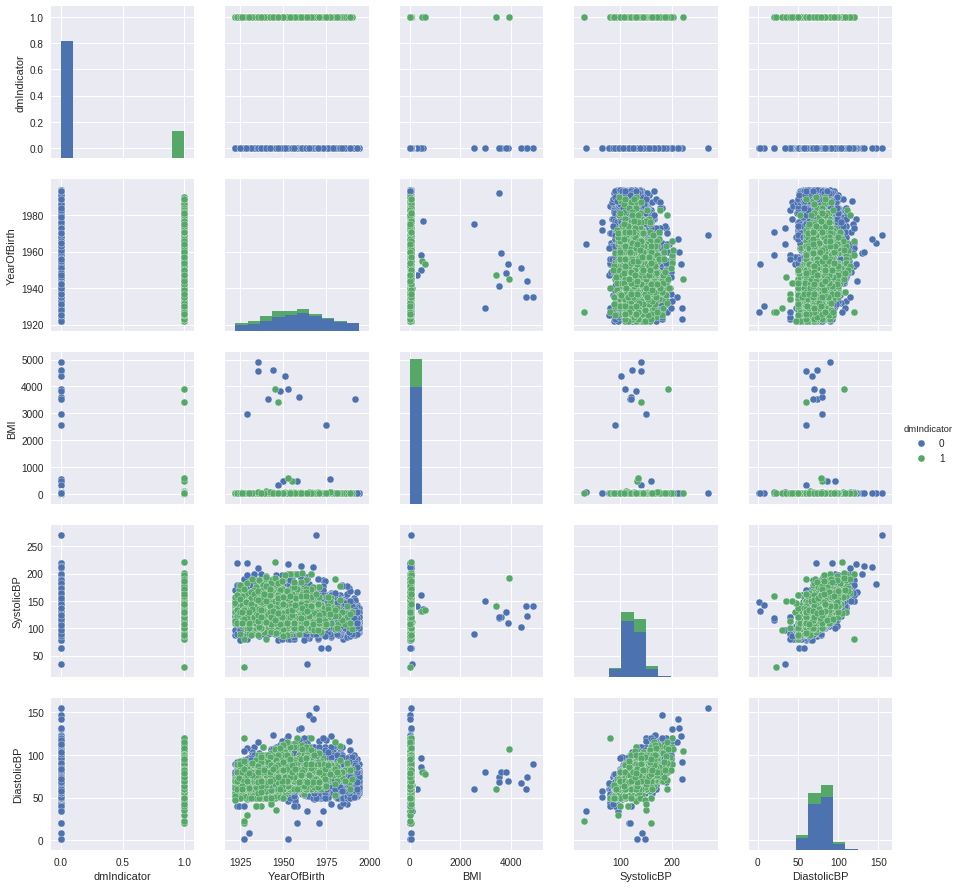

In [82]:
sns.pairplot(patientTranscripts, hue="dmIndicator");